# Your own recommender system

In this task we will take a look at music recommendations.

You will compare iALS with item-based recommendations and a simple bestsellers baseline by NDCG.

This assignment is graded by your `submission.json`.

The cell below creates a valid `submission.json` file, fill your answers in there. 

You can press "Submit Assignment" at any time to submit partial progress.

In [ ]:
%%file submission.json
{
    "q1": 0.6611500770764906,
    "q2": 0.709517848993041,
    "q3": "OneRepublic",
    "q4": 0.300
}

Writing submission.json


# Imports

In [ ]:
%config IPCompleter.greedy=True
%env OPENBLAS_NUM_THREADS=1
import pandas as pd
#import implicit
from sklearn.model_selection import train_test_split
import scipy.sparse as sps
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from collections import defaultdict

env: OPENBLAS_NUM_THREADS=1


# Yandex.Music dataset

In [ ]:
#! ls -lh yandex_music

In [ ]:
#! head -n 5 yandex_music/artists.jsonl

In [ ]:
#! head -n 5 yandex_music/events.csv

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
train_data_location = "/content/gdrive/My Drive/Colab Notebooks/"

Mounted at /content/gdrive


# Loading dataset

In [ ]:
#artists = pd.read_json("yandex_music/artists.jsonl", orient='records', lines=True)
artists = pd.read_csv(train_data_location + 'artists.csv')

print(artists.dtypes)
artists.head(5)

artistId       int64
artistName    object
dtype: object


,artistId,artistName
0,0,Mack Gordon
1,1,Kenny Dorham
2,2,Max Roach
3,3,Francis Rossi
4,4,Status Quo


In [ ]:
#events = pd.read_csv("yandex_music/events.csv")
events = pd.read_csv(train_data_location + 'events.csv')
print(events.dtypes)
events.head()

userId      int64
artistId    int64
plays       int64
skips       int64
dtype: object


,userId,artistId,plays,skips
0,0,335,1,0
1,0,708,1,0
2,0,710,2,1
3,0,815,1,1
4,0,880,1,1


In [ ]:
# statistics
print("users:", len(set(events.userId)))
print("items:", len(set(events.artistId)))
print("interactions:", len(events))
print("density:", len(events) / (len(set(events.userId)) * len(set(events.artistId))))

users: 4999
items: 53031
interactions: 3412504
density: 0.012872420423252307


In [ ]:
# most popular artists
(
    events
    .merge(artists)[['artistName', 'plays']]
    .groupby("artistName").sum()
    .sort_values('plays', ascending=False)
    .head(10)
)

,plays
artistName,
Imagine Dragons,43447
Би-2,29415
Баста,27264
Ленинград,26311
Сплин,25062
Queen,24905
Sia,22803
LOBODA,21923
Noize MC,21774


In [ ]:
# train / test split
train, test = train_test_split(events, test_size=0.05, random_state=0)
print(train.shape)
print(test.shape)

(3241878, 4)
(170626, 4)


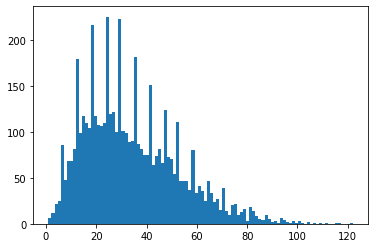

In [ ]:
# number of artists per user in the test set
_ = plt.hist(test.groupby('userId').count()['plays'], bins=100)

# Train iALS

Let's say that confidence is `1 + 10 * log2(plays + 1)`

In [ ]:
# prepare matrix for implicit library (https://implicit.readthedocs.io/en/latest/models.html)
# item_user (sparse csr_matrix) of item/user/confidence
# csc_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#     where ``data``, ``row_ind`` and ``col_ind`` satisfy the
#     relationship ``a[row_ind[k], col_ind[k]] = data[k]``.

item_user_train = sps.csc_matrix((1 + 10 * np.log2(train.plays + 1), (train.artistId, train.userId)))
item_user_train

<70818x4999 sparse matrix of type '<class 'numpy.float64'>'
	with 3241878 stored elements in Compressed Sparse Column format>

In [ ]:
%%time
model = implicit.als.AlternatingLeastSquares(factors=32, iterations=10, random_state=0)
model.fit(item_user_train)

NameError: ignored

# Similar artists (via iALS)

Let's find similar artists by cosine between their embeddings

In [ ]:
target_artists = artists[artists.artistName.isin(['Coldplay', '50 Cent', 'AC/DC'])]
target_artists

,artistId,artistName
404,404,Coldplay
647,647,50 Cent
33965,33965,AC/DC


In [ ]:
artist_to_name = dict(zip(artists.artistId, artists.artistName))
for _, row in target_artists.iterrows():
    print("#############", row.artistName, "#############")
    for a, s in model.similar_items(row.artistId, N=5):
        print(artist_to_name[a], "\t", s)

############# Coldplay #############


NameError: ignored

# NDCG metric

In [ ]:
from sklearn.metrics import ndcg_score

In [ ]:
# how ndcg works in sklearn (true scores are used without exponentiation)
print(ndcg_score(y_true=[[  0,   0,   2,   1,   0]], 
                 y_score=[[0.2, 0.1, 0.5, 0.3, 0.4]]))
print((2 / np.log(1 + 1) + 1 / np.log(3 + 1)) / 
      (2 / np.log(1 + 1) + 1 / np.log(2 + 1)))

0.9502344167898358
0.9502344167898358


# NDCG for baseline

__q1: Let's compute NDCG for non-personalized baseline on the test set.__

Let's say that we rank test artists for each user by their global popularity (the sum of plays in the training dataset).

_Make sure to compute NDCG only for users with at least 2 different artists in the test set._

In [ ]:
test.shape

(170626, 4)

In [ ]:
test.groupby('userId').count()['artistId'].sort_values()

userId
4206      1
429       1
1474      1
845       2
4973      2
       ... 
96      109
2316    112
4080    115
2345    116
1301    122
Name: artistId, Length: 4997, dtype: int64

In [ ]:
users_to_drop = [4206, 429, 1474]

In [ ]:
test_clean = test.drop(test[test.userId.isin(users_to_drop)].index)

In [ ]:
test_clean.shape

(170623, 4)

In [ ]:
g_pop = (
    train[['artistId', 'plays']]
    .groupby('artistId')
    .sum()
    )

In [ ]:
df = test_clean.join(g_pop, on='artistId', lsuffix='_x', rsuffix='_y')

In [ ]:
df.fillna(0, inplace=True)

In [ ]:
user_ids = df.userId.unique()

In [ ]:
ndcg = []

for u in user_ids:
    y_true = df[df.userId == u].plays_x.values
    y_score = df[df.userId == u].plays_y.values
    ndcg.append(ndcg_score(y_true=[y_true], y_score=[y_score]))

In [ ]:
sum(ndcg)/len(ndcg)

0.6611500770764906

# NDCG for iALS

__q2: Now let's replace global popularity with iALS prediction for each user.__

_Make sure to compute NDCG only for users with at least 2 different artists in the test set._

In [ ]:
# prediction for user 100 and item 200 (a simple dot product):
print(model.user_factors[100].dot(model.item_factors[200]))

NameError: ignored

In [ ]:
# YOUR CODE HERE
df

,userId,artistId,plays_x,skips,plays_y
564228,1244,47785,1,0,143.0
3388837,4881,15996,0,1,4802.0
676253,1496,63240,6,5,4191.0
549629,1211,1120,6,3,455.0
503021,1105,7636,1,0,14.0
...,...,...,...,...,...
3148855,3790,20291,0,1,1458.0
1352451,2962,38645,1,0,98.0
2820055,2357,23579,0,4,4836.0
2929571,2814,36773,0,2,9.0


In [ ]:
def als_cal(row):
    user = np.int32(row['userId'])
    item = np.int32(row['artistId'])
    print(user, item)
    als = model.user_factors[user].dot(model.item_factors[item])
    return als

In [ ]:
df['plays_als'] =df.apply (lambda row: als_cal(row), axis=1)

NameError: ignored

In [ ]:
df

,userId,artistId,plays_x,skips,plays_y,plays_als
564228,1244,47785,1,0,143.0,0.448125
3388837,4881,15996,0,1,4802.0,0.817293
676253,1496,63240,6,5,4191.0,0.907167
549629,1211,1120,6,3,455.0,0.822932
503021,1105,7636,1,0,14.0,0.433467
...,...,...,...,...,...,...
3148855,3790,20291,0,1,1458.0,0.494736
1352451,2962,38645,1,0,98.0,0.520342
2820055,2357,23579,0,4,4836.0,0.991911
2929571,2814,36773,0,2,9.0,0.020353


In [ ]:
ndcg = []

for u in user_ids:
    y_true = df[df.userId == u].plays_x.values
    y_score = df[df.userId == u].plays_als.values
    ndcg.append(ndcg_score(y_true=[y_true], y_score=[y_score]))

AttributeError: ignored

In [ ]:
sum(ndcg)/len(ndcg)

ZeroDivisionError: ignored

# Jaccard similarities

Let's compute Jaccard similarities for pairs of artists in the training dataset. 

Here're some details:
- Take into account only artists that the user has played at least 3 times (to cut off random plays).
- Compute jacccard similarity only for pairs that have at least 50 common users (to get confident estimates).

__q3: We will use it to recommend similar artists for users in the test set, but first let's find most similar artist to "Maroon 5" (other than "Maroon 5").__

In [ ]:
from sklearn.metrics import jaccard_score

In [ ]:
# each user has less than N=1000 artists, so N^2 is not that big
(
    train[train.plays >= 3]
    .groupby("userId").count()
    .sort_values("plays", ascending=False)
    .head(5)
)

,artistId,plays,skips
userId,,,
4689,614,614,614
4575,550,550,550
3121,548,548,548
2266,497,497,497
1168,479,479,479


In [ ]:
# YOUR CODE HERE

def jaccard_similarity(a, b):
    # convert to set
    a = set(a)
    b = set(b)
    # calucate jaccard similarity
    j = float(len(a.intersection(b))) / len(a.union(b))
    return j

In [ ]:
l1 = [1, 2, 3]
l2 = [1, 2, 4]
jaccard_similarity(l1, l2)

0.5

In [ ]:
train_3 = train[train.plays >= 3]

In [ ]:
artists.loc[artists['artistName'] == 'Maroon 5']

,artistId,artistName
14803,14803,Maroon 5


In [ ]:
artist_ids = train_3['artistId'].unique()

In [ ]:
result = []
M5 = set(train_3.loc[train_3['artistId'] == 14803]['userId'].values)

for a in artist_ids:
    
    a1 = set(train_3.loc[train_3['artistId'] == a]['userId'].values)
    
    if len(M5.intersection(a1)) >= 50:
        j = float(len(M5.intersection(a1))) / len(M5.union(a1))
        result.append((a, j))
        

NameError: ignored

In [ ]:
sorted(result, key=lambda tup: tup[1], reverse=True)[1][1]

0.3138075313807531

In [ ]:
artists.loc[artists['artistId'] == 3568]

,artistId,artistName
3568,3568,OneRepublic


# NDCG for item-based collaborative filtering (with Jaccard similarities)

Let's compute our `prediction` for test `item` like follows:
```python
prediction = 0
for history_item, history_plays in user_train_history:
    prediction += jaccard[(history_item, item)] * history_plays
```

__q4: What NDCG do we have for item-based recommendations?__

_Make sure to compute NDCG only for users with at least 2 different artists in the test set._

In [ ]:
artist_ids = train_3['artistId'].unique()

def jaccard(item1, item2):
    
    result = []
    
    i1_set = set(train_3.loc[train_3['artistId'] == item1]['userId'].values)
    #print('i1:', i1_set, '\n\n')
    i2_set = set(train_3.loc[train_3['artistId'] == item2]['userId'].values)
    #print('i2:', i2_set)

    if len(i1_set.intersection(i2_set)) >= 50:
        j = float(len(i1_set.intersection(i2_set))) / len(i1_set.union(i2_set))
    else:
        j = 0.0
    
    return j

In [ ]:
jaccard(14803, 3568)

0.3138075313807531

In [ ]:
y_pred = []
cache = {}

for uid, item in tqdm.tqdm(test_clean[['userId', 'artistId']].values):
    prediction = 0
    
    for history_item, history_plays in train_3[train_3['userId'] == uid][['artistId', 'plays']].values:
        if(history_item, item) in cache:
            prediction += cache[history_item, item] * history_plays
        else:
            j_sim = jaccard(history_item, item)
            prediction += j_sim * history_plays
            cache[(history_item, item)] = j_sim
            cache[(item, history_item)] = j_sim
    y_pred.append(prediction)

 96%|█████████▌| 163722/170623 [7:00:14<12:13,  9.41it/s]

In [ ]:
y_pred = pd.Series(y_pred)
y_pred

In [ ]:
test_clean.shape

In [ ]:
test_clean1 = test_clean.reset_index(drop=True)

In [ ]:
test_with_pred = pd.concat([test_clean1, y_pred], axis = 1, ignore_index=False)

In [ ]:
test_with_pred

In [ ]:
test_with_pred.rename(columns={0:'plays_y'}, inplace=True)

In [ ]:
test_with_pred

In [ ]:
user_ids = test_with_pred['userId'].unique()

ndcg = []

for u in user_ids:
    y_true = test_with_pred[test_with_pred.userId == u].plays.values
    y_score = test_with_pred[test_with_pred.userId == u].plays_y.values
    ndcg.append(ndcg_score(y_true=[y_true], y_score=[y_score]))

In [ ]:
sum(ndcg)/len(ndcg)